('Route Sequence:  E, y, s, t, h, }, X, r, u, `, p, _, P, a, R, j, x, U, v, w, L, I, O, N, i, J, \\, b, q, ^, Y, o, A, z, D, ], e, V, Z, |, l, W, n, K, {, F, [, C, T, c, Q, G, H, S, m, ~, M, g, d, k, B, f ', '\n')
Distance of tour: 5724.13



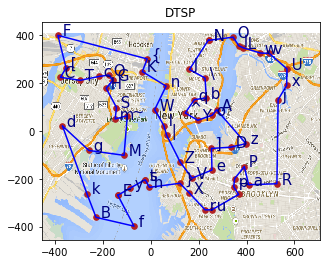

In [76]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt

def retrieveData():
    data = list(csv.reader(open('test1.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

def retrievePreviousData():
    data = list(csv.reader(open('prevTour.csv')))[0]
    return data

class ACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            exploration = random.uniform(0.0,1.0)
            if exploration < 0.10: #randomly explore
                min = float("inf")
                for unvisited_node in unvisited_nodes:
                    if self.edges[self.tour[-1]][unvisited_node].weight < min:
                        min = self.edges[self.tour[-1]][unvisited_node].weight
                        min_node = unvisited_node
                explored_node = min_node
                return explored_node
            else:
                roulette_wheel = 0.0
                for unvisited_node in unvisited_nodes: 
                    roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                      pow((1.0 / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                random_value = random.uniform(0.0, 1.0)
                wheel_position = 0.0
                for unvisited_node in random.sample(unvisited_nodes,len(unvisited_nodes)):
                    wheel_position += (pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                      pow((1.0 / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)) / roulette_wheel
                    if wheel_position >= random_value:
                        return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, jump_pheromone=1.5, steps=100, nodes=None, labels=None, previous_path=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        if previous_path != None:
            for i in range(len(previous_path)):
                if (previous_path[i-1] in labels) and (previous_path[i] in labels):
                    for j in range(len(labels)): #find index-1
                        if previous_path[i-1] == labels[j]:
                            for k in range(len(labels)):#find index-2
                                if previous_path[i] == labels[k]:
                                    self.edges[j][k].pheromone = jump_pheromone
                                    self.edges[k][j].pheromone = jump_pheromone
        
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _elitist_acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def run(self):
        self._elitist_acs()
        print('Route Sequence: {0} '.format(','.join(str(self.labels[i]) for i in self.global_best_tour)),'\n')
        csv_str = [self.labels[i] for i in self.global_best_tour]
        with open("prevTour.csv",'wb') as resultFile:
            wr = csv.writer(resultFile, dialect='excel')
            wr.writerow(csv_str)
        print('Distance of tour: {0}\n'.format(round(self.global_best_distance, 2)))

    def sketch(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        fig, ax = plt.subplots()
        ax.imshow(img, extent=[-455, 705, -455, 405])
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()

if __name__ == '__main__':
    coordinates, places = retrieveData()
    previous_data = retrievePreviousData()
    _colony_size = 20
    _steps = 350
    _nodes = coordinates
    elitist_instance = ACO(mode='DTSP', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places, previous_path=previous_data)
    elitist_instance.run()
    elitist_instance.sketch()

** Store old pheromone values, use function from [13],[14] **

** Create time slices - compare visited vs new and elminate visited nodes and rerun**


* Setting step size *

* Why can't I use random.seed(0) *


In [297]:
import csv
data = list(csv.reader(open('datafile.csv')))
for i in data:
    i[0] = float(i[0])
    i[1] = float(i[1])
lattitude = [i[0] for i in data]
longitude = [i[1] for i in data]
coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
places = [i[2] for i in data]
print (data)
print('lattitude: ', lattitude)
print('longitude: ', longitude)
print('coordinates: ', coordinates)
print('places: ', places)

[[300.0, 200.0, 'Office'], [-300.0, 150.0, 'Plant'], [-200.0, 300.0, 'Home'], [0.0, -350.0, 'Park'], [-25.0, 220.0, 'Garage'], [15.0, 84.0, 'Work'], [210.0, -97.0, 'Factory']]
lattitude:  [300.0, -300.0, -200.0, 0.0, -25.0, 15.0, 210.0]
longitude:  [200.0, 150.0, 300.0, -350.0, 220.0, 84.0, -97.0]
coordinates:  [[300.0, 200.0], [-300.0, 150.0], [-200.0, 300.0], [0.0, -350.0], [-25.0, 220.0], [15.0, 84.0], [210.0, -97.0]]
places:  ['Office', 'Plant', 'Home', 'Park', 'Garage', 'Work', 'Factory']


In [77]:
#Create Data Points (coordinates and locations)
import random 
A=400*random.random()

for i in range(62):
    print random.uniform(-400, 600),',', random.uniform(-400, 400),',', chr(65+i)

-378.632370489 , 23.932209051 , A
311.574094264 , -265.367278595 , B
244.738631778 , -106.996884166 , C
-43.99224874 , 341.294854397 , D
557.354991748 , -370.261450791 , E
250.138805553 , 229.684916397 , F
568.669187801 , 148.182632902 , G
182.768169293 , 393.809443213 , H
507.81279093 , -15.9413200784 , I
192.900734537 , -303.372965395 , J
353.124959392 , 391.849557047 , K
174.973813682 , -16.3256804191 , L
-93.3494616237 , -21.3060285942 , M
-231.410455927 , -256.382908659 , N
492.497872758 , 352.553697217 , O
424.470050607 , 367.076097571 , P
325.143287871 , 342.914494563 , Q
151.577777062 , 241.198442174 , R
574.719350789 , 258.480131153 , S
66.1706250156 , -180.40508654 , T
-245.67528386 , 108.728977789 , U
-318.056472141 , -5.65186972433 , V
-363.641355022 , 348.732854713 , W
90.829225739 , -22.4952298951 , X
316.808945647 , 117.110184246 , Y
-344.896986814 , -355.084589332 , Z
-164.871182146 , -386.796132664 , [
121.053287919 , -82.1229932692 , \
406.128100485 , 88.6903386683 , 

In [53]:
#Create Data Points (coordinates and locations)
import random 
A=400*random.random()

for i in range(62):
    print random.uniform(-400, 600),',', random.uniform(-400, 400),',', chr(65+i)

275.053362242 , 87.8278079937 , A
-228.2902674 , -361.256436149 , B
-376.892261029 , 223.150598795 , C
334.450937377 , -68.3755657224 , D
-137.255840821 , -269.011945389 , E
-387.383619101 , 398.313748303 , F
-158.017026176 , 210.945084118 , G
-185.859140285 , 177.562124885 , H
368.068039077 , 354.410426033 , I
161.617645015 , 255.895493193 , J
-35.0703560029 , 247.079467627 , K
387.232219485 , 346.090727943 , L
-111.366184386 , -102.477120342 , M
242.29888409 , 377.516351704 , N
343.741570987 , 390.821196281 , O
390.652246645 , -149.611546891 , P
-174.874458567 , 232.629441003 , Q
526.712779044 , -221.012760197 , R
-142.857223121 , 97.1311422043 , S
-294.198126408 , 210.685555445 , T
568.77814761 , 258.290077747 , U
172.754318753 , -197.715591482 , V
16.4347640802 , 88.0370029723 , W
160.34841822 , -258.749989517 , X
196.491486267 , 43.8329278321 , Y
123.383397169 , -131.179411319 , Z
-353.227588888 , 262.554720241 , [
226.753564642 , 220.188268823 , \
253.506320313 , -73.7143135574 ,

In [52]:
#Create Data Points (coordinates and locations)


import csv
import random 
count = 62
random_coordinates = [[] for i in range(count)]
for i in range(count):
    random_coordinates[i].append(random.uniform(-400, 600))
    random_coordinates[i].append(random.uniform(-400, 400))
    random_coordinates[i].append(chr(65+i))
    print random_coordinates[i]

with open('test2.csv', 'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(random_coordinates)
count = 0

[-330.8839614468145, 118.69060606127186, 'A']
[383.58400116692235, -389.5997262838801, 'B']
[62.01578327829617, -14.024255467874696, 'C']
[-389.13261445212976, 80.54755130494271, 'D']
[114.56792728422249, 261.6519213023121, 'E']
[141.80606600230442, 210.87813319772908, 'F']
[75.27075333317748, -254.83772137839952, 'G']
[544.9422312019091, 287.46376215382134, 'H']
[549.7362815563897, -384.4559413101079, 'I']
[187.78234466863205, 63.41256564347407, 'J']
[-143.97667625047183, 1.3627609972432424, 'K']
[-216.87738939212417, 12.550511232692145, 'L']
[494.6406513553093, 16.110513245962295, 'M']
[-339.1842196183184, -16.09488220670829, 'N']
[-120.71269014389918, -168.35553406427258, 'O']
[225.21584261232238, 36.395636765523136, 'P']
[143.14693892804212, -179.86861021902288, 'Q']
[-46.052154213765846, 134.3656414236375, 'R']
[241.94635239647687, 52.521642115545944, 'S']
[464.8800211097133, -129.84367511781596, 'T']
[474.3604864123297, 249.41405543582778, 'U']
[73.16938808501232, 239.93092407345

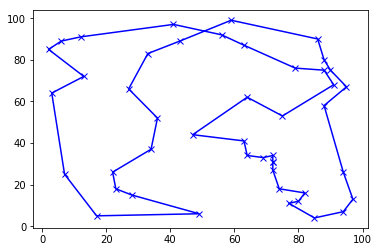

In [69]:
import random, numpy, math, copy, matplotlib.pyplot as plt
cities = [random.sample(range(100), 2) for x in range(45)];
tour = random.sample(range(45),45);
for temperature in numpy.logspace(0,5,num=100000)[::-1]:
    [i,j] = sorted(random.sample(range(45),2));
    newTour =  tour[:i] + tour[j:j+1] +  tour[i+1:j] + tour[i:i+1] + tour[j+1:];
    if math.exp( ( sum([ math.sqrt(sum([(cities[tour[(k+1) % 45]][d] - cities[tour[k % 45]][d])**2 for d in [0,1] ])) for k in [j,j-1,i,i-1]]) - sum([math.sqrt(sum([(cities[newTour[(k+1) % 45]][d] - cities[newTour[k % 45]][d])**2 for d in [0,1] ])) for k in [j,j-1,i,i-1]])) / temperature) > random.random():
        tour = copy.copy(newTour);
plt.plot(zip(*[cities[tour[i % 45]] for i in range(46) ])[0], zip(*[cities[tour[i % 45]] for i in range(46) ])[1], 'xb-', );
plt.show()